In [2]:
# importa las librerias necesarias 
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# lee el archivo parquet 
df_raw = pd.read_parquet("../data/reservas_hoteles.parquet")
df_raw.sample(5)

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
10077,88d7f599-818e-436b-85aa-a542b3d68a6b,7515f0ec-5d88-4ed7-9689-40d4b5a81aad,Lucho,Alemany,lucho.alemany@example.com,False,2025-02-04,2025-03-01,2025-03-02,14,136.78,Hotel Palacio Imperial,3.0,Madrid
7138,91eda978-3ffe-461e-93f3-83d0156fba3a,5310b2d9-6370-4567-a881-29a92348aa5a,Roberto,Mulet,roberto.mulet@example.com,False,2025-02-04,2025-03-01,2025-03-02,28,443.64,Hotel Brisas del Mar,3.0,Madrid
12537,32987cf2-4e0f-4ab4-bee2-eb6065071f51,89dfd610-8bbb-4c35-9d0a-74948a2d244e,Chucho,Jódar,chucho.jódar@example.com,True,,2025-03-01,2025-03-02,117,NaN,,NaN,
13325,99b96ef7-ab2a-4816-834a-4a277d8bfcdc,0052f6c0-0d83-4b8d-b162-adce31c3954d,Víctor,Folch,víctor.folch@example.com,True,,2025-03-01,2025-03-02,128,NaN,,NaN,
7806,9eca9671-ac2c-4c42-b0b1-c9d3e38b91f7,4785dd25-5547-4a8b-930d-e63d76d998bc,Balduino,Bustos,balduino.bustos@example.com,False,2025-02-01,2025-03-01,2025-03-02,27,345.75,Palacio del Sol,3.0,Madrid


In [4]:
# realiza una copia del archivo original
df = df_raw.copy()

In [5]:
# saca la forma del dataframe
df.shape

(15098, 14)

In [6]:
# crea una funcion que genera un reporte con informacion de nulos y tipo de dato de cada una de las columnas 
def info_reporte(dataframe):
    df_report = pd.DataFrame()
    df_report["Numero_nulos"] = dataframe.isnull().sum()
    df_report["Porcentaje_nulos"] = round((dataframe.isnull().sum()/dataframe.shape[0]*100), 2)
    df_report["Tipo_dato"] = dataframe.dtypes
    return df_report

In [7]:
# llama a la funcion aplicandola al dataframe 
info_reporte(df)

,Numero_nulos,Porcentaje_nulos,Tipo_dato
id_reserva,0,0.00,object
id_cliente,0,0.00,object
nombre,0,0.00,object
apellido,0,0.00,object
mail,0,0.00,object
competencia,0,0.00,bool
fecha_reserva,0,0.00,object
inicio_estancia,75,0.50,object
final_estancia,75,0.50,object
id_hotel,0,0.00,int64


In [8]:
# saca los valores únicos de la columna estrellas
df["estrellas"].unique()

array([nan,  1.,  5.,  4.,  3.,  2.])

- Tengo 15098 entradas y contamos con 14 columnas 
- En cuanto al tipo de dato de las columnas, ya se identifican determinadas columnas cuyo tipo de dato es incorrecto, concretamente las columnas de tipo datetime que están en tipo object. Es decir, fecha_reserva, inicio_estancia y final_estancia. El resto parecen estar correctamente. En cuanto a la columna de estrellas, se observa que cuenta con 5 valores únicos, es decir, no recoge números de estrellas que no sean enteros tipo 4.3, sino que solo dispone de los valores: 1,2,3,4,5, con lo que en principio debería estar en tipo integer. 
- Nos faltaría la columna de id_ciudad que va a ser creada en la carga de los datos, de la tabla ciudad, al ser una columna con id seriados. Por otro lado, nos falta la tabla entera de eventos con todas sus columnas (la vamos a obtener del escrapeo a través de la api).
- Observación primera de nulos: Contamos con nulos en 4 columnas (inicio_estancia, final_estancia, precio_noche, estrellas)

In [9]:
# convierte el tipo de dato de las 3 columnas de fecha en tipo datetime
col_fechas = ["fecha_reserva", "inicio_estancia", "final_estancia"]
for col in col_fechas:
    df[col] = pd.to_datetime(df[col])

In [10]:
# convierte la columna estrellas de tipo float a tipo integer 
df["estrellas"] = df["estrellas"].astype("Int64")

In [11]:
# comprueba que se han cambiado correctamente los tipos de dato de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15098 non-null  object        
 1   id_cliente       15098 non-null  object        
 2   nombre           15098 non-null  object        
 3   apellido         15098 non-null  object        
 4   mail             15098 non-null  object        
 5   competencia      15098 non-null  bool          
 6   fecha_reserva    9926 non-null   datetime64[ns]
 7   inicio_estancia  15023 non-null  datetime64[ns]
 8   final_estancia   15023 non-null  datetime64[ns]
 9   id_hotel         15098 non-null  int64         
 10  precio_noche     9874 non-null   float64       
 11  nombre_hotel     15098 non-null  object        
 12  estrellas        9926 non-null   Int64         
 13  ciudad           15098 non-null  object        
dtypes: Int64(1), bool(1), datetime64[ns](3

In [12]:
# saca el numero de duplicados por todas las columnas que hay en el dataframe
df.duplicated().sum()

np.int64(98)

In [13]:
# elimina los duplicados por todas las columnas del dataframe 
df.drop_duplicates(inplace=True)

In [14]:
# comprueba si hay duplicados por la columna id_reserva
df["id_reserva"].duplicated().sum()

np.int64(0)

In [15]:
# saca la forma del dataframe tras haber eliminado duplicados
df.shape

(15000, 14)

En cuanto a los duplicados, contamos con 98 duplicados por todas las columnas. Es decir, reservas que están completamente repetidas. En este caso, las eliminamos del conjunto de datos  nos quedamos con 15000 reservas. Además, una vez eliminadas estas reservas es importante observar si por el campo "id_reserva" hay algún duplicado, y ¿por qué? pues porque id_reserva es el identificador único de cada reserva (cada registro) y no puede estar repetido. Comprobamos que no hay duplicados por este campo y por lo tanto, todas las reservas son únicas y estaría todo correcto. Por el resto de id como el id_cliente o el id_hotel no hay que comprobarlo ya que por estos campos sí pueden haber duplicados. Pueden haber clientes que hayan realizado más de una reserva o hoteles que hayan sido reservados en más de una ocasión.

En cuanto a los valores nulos, de primeras parecía que únicamente habían 4 columnas con valores nulos (inicio_estancia, final_estancia, precio_noche, estrellas), pero por lo que he observado en estos primeros vistazos sobre el conjunto de datos, las columnas fecha_reserva, nombre_hotel y ciudad también tienen valores faltantes, lo que ocurre es que son espacios en blanco y no se están contando como valores nulos porque pandas no lo está identificando así. Además, parece que los nulos tienen que ver con los hoteles de la competencia. Lo primero que voy a hacer es convertir esos espacios en blanco en valores nulos para hacer un recuento correcto de los mismos.

In [16]:
# reemplaza los valores en blanco por valores nulos 
col_blancos = ["fecha_reserva", "nombre_hotel", "ciudad"]
for col in col_blancos:
    df[col] = df[col].replace("", np.nan)

In [17]:
# llama a la funcion reporte aplicandola al dataframe 
info_reporte(df)

,Numero_nulos,Porcentaje_nulos,Tipo_dato
id_reserva,0,0.00,object
id_cliente,0,0.00,object
nombre,0,0.00,object
apellido,0,0.00,object
mail,0,0.00,object
competencia,0,0.00,bool
fecha_reserva,5172,34.48,datetime64[ns]
inicio_estancia,75,0.50,datetime64[ns]
final_estancia,75,0.50,datetime64[ns]
id_hotel,0,0.00,int64


In [18]:
# recuento de hoteles de competencia 
df[df["competencia"] == True].shape[0]

5172

Observamos como ahora ya si nos está sacando el recuento y el porcentaje de nulos de todas las columnas. De primeras ya es curioso que las columnas fecha_reserva, nombre_hotel, estrellas y ciudad tengan el mismo número de nulos, por lo de que parece que tienen relación con los hoteles de competencia. Y, efectivamente, coincide con el número de reservas que provienen de hoteles de la competencia (5172). Por lo tanto, algunas de ellas parecen que se van a sacar a través de web scraping, como la de nombre_hotel y la de estrellas. En el caso de la columna de ciudad no sería necesario web scraping, pues conocemos que los hoteles de la competencia también están ubicados en Madrid y, por lo tanto, podemos rellenar directamente con "Madrid".

In [19]:
# reemplaza los nulos de la columna ciudad por "Madrid"
df["ciudad"] = df["ciudad"].fillna("Madrid")

DUDA MARTES: y el dato de fecha de reserva como se saca? de donde y tal?

In [20]:
# saca el numero de valores unicos de las columnas inicio_estancia y final_estancia
df[["inicio_estancia", "final_estancia"]].nunique()

inicio_estancia    1
final_estancia     1
dtype: int64

Por otro lado, en cuanto a las columnas de inicio_estancia y final_estancia, del primer vistazo de los datos, también he podido observar que por lo que parece, ambas disponen de un único valor, y además, lo he comprobado, y es así. Es decir, para todas las reservas, la fecha de inicio de la estancia es la misma, concretamente el 1 de marzo de 2025, y para todas las reservas la fecha de fin de estancia también es la misma, concretamente el 2 de marzo de 2025, es decir, se están recogiendo datos de reservas exclusivas de una estancia de 1 día, concretamente entre el 1 y el 2 de marzo. En este caso, los valores nulos de ambas columnas, que encima suponen un porcentaje ínfimo en cada una de ellas (0,5%) también pueden ser rellenados con las mismas fechas.

In [21]:
# rellena los valores nulos de las columnas inicio_estancia y final_estancia por la unica fecha existente en cada columna
fechas_estancia = ["inicio_estancia", "final_estancia"]
for col in fechas_estancia:
    df[col] = df[col].fillna(df[col].dropna().unique()[0])

Por último, la última columna que tiene nulos es el precio_noche. Hay nulos en esta columna para 52 reservas de hoteles propios, y el resto de nulos corresponden a todos los hoteles de la competencia, es decir, un dato igualmente a scrapear en el caso de los hoteles de la competencia. En el caso de los hoteles propios, hay que valorar como tratar estos 52 registros nulos.

In [22]:
# saca el numero de reservas correspondientes con hoteles propios y con precio_noche nulo
numero_reservas = df[(df["competencia"] == False) & (df["precio_noche"].isna())].shape[0]
print(numero_reservas)
numero_hoteles_competencia = df[df["precio_noche"].isna()].shape[0] - numero_reservas
print(numero_hoteles_competencia)

52
5172


In [23]:
# saca los hoteles y el numero de registros por cada hotel donde precio_noche es nulo
df_nulos_precio = df[(df["competencia"] == False) & (df["precio_noche"].isna())]
df_nulos_precio["nombre_hotel"].value_counts()

nombre_hotel
Hotel Sol y Luna          5
Hotel Torre Dorada        5
Hotel Camino del Sol      4
Hotel Mirador Real        4
Hotel Las Estrellas       4
Hotel Monte Verde         4
Hotel Puerta del Cielo    3
Hotel Encanto Real        3
Palacio del Sol           3
Gran Hotel Madrid         3
Hotel Brisas del Mar      2
Hotel Los Almendros       2
Hotel Vista Alegre        2
Hotel Rincón Sereno       2
Hotel Costa Azul          2
Hotel Luz de Madrid       1
Hotel Jardines del Rey    1
Hotel Palacio Imperial    1
Hotel Maravilla Real      1
Name: count, dtype: int64

In [24]:
# filtra por el hotel "Hotel Sol y Luna"
df[df["nombre_hotel"] == "Hotel Sol y Luna"].sample(5)

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
10852,9d81c242-8d3b-415a-9115-c1673c6f8db6,714ec908-2a27-427b-b86c-67470f4431e0,Quique,Arnaiz,quique.arnaiz@example.com,False,2025-02-03,2025-03-01,2025-03-02,36,486.91,Hotel Sol y Luna,4,Madrid
12316,4927ed01-391a-46c5-b6d5-92a423b060b9,c602f082-6ae3-4906-b730-85419dea850d,José Luis,Pascual,josé luis.pascual@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,294.44,Hotel Sol y Luna,1,Madrid
12351,904d6d91-fd7b-4eda-9fe1-9cf6124d8a2f,a1d860ce-eedb-430a-8ccf-9ac5caaa7069,Estefanía,Balaguer,estefanía.balaguer@example.com,False,2025-02-02,2025-03-01,2025-03-02,40,97.49,Hotel Sol y Luna,2,Madrid
4832,07a86b9a-4f67-4d39-8142-2727c2f301d6,18c4b77d-c937-44ac-bdb7-b28a94c81703,Zoraida,Revilla,zoraida.revilla@example.com,False,2025-02-10,2025-03-01,2025-03-02,28,145.40,Hotel Sol y Luna,3,Madrid
1685,a7fdae10-ff26-48f1-92d9-5d257c4380bf,74efc341-0069-4e2e-99f1-0d825ac36dd4,Nerea,Rocha,nerea.rocha@example.com,False,2025-02-06,2025-03-01,2025-03-02,27,116.97,Hotel Sol y Luna,1,Madrid


Como se puede observar, para por ejemplo el Hotel Sol y Luna el precio_noche es diferente para cada reserva, pues al final aunque la estancia vaya a ser el mismo día, los precios van fluctuando por momentos, y si por ejemplo reservas con más antelación, probablemente pues el precio por noche será menor. Lo que se puede valorar es sustituir los pocos nulos que hay por cada hotel por la media o la mediana (en función de los outliers) de la columna precio_noche para cada hotel. 

DUDA MARTES: sacando esta informacion me he dado cuenta de que hay algo raro porque el Hotel Sol y Luna en Madrid que deberia ser el mismo claro, tiene para cada reserva un id_hotel diferente cuando deberia ser el mismo y también estrellas diferentes. ??????

Outliers de la columna precio_noche

In [25]:
# saca los estadisticos de precio_noche
df["precio_noche"].describe()

count    9776.000000
mean      275.066498
std       129.501317
min        50.010000
25%       163.062500
50%       273.420000
75%       387.810000
max       499.820000
Name: precio_noche, dtype: float64

Text(0.5, 1.0, 'Histograma de Precio_noche')

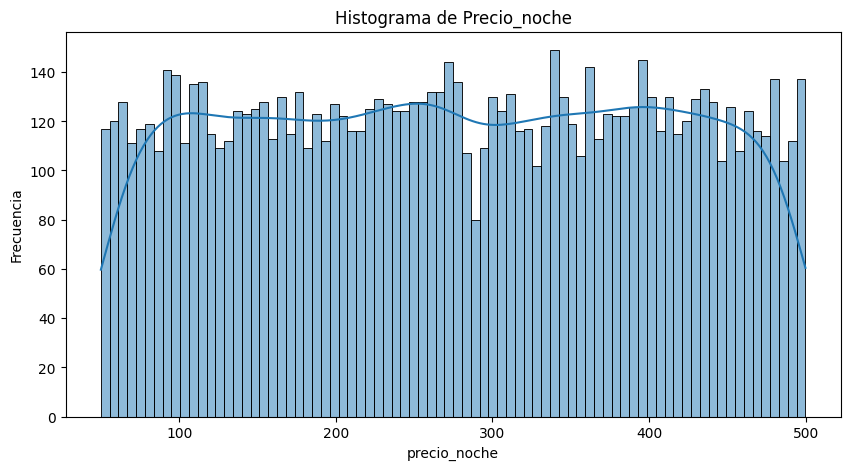

In [26]:
# para ver la distribucion de los datos
plt.figure(figsize=(10,5))
sns.histplot(df["precio_noche"], 
             bins=80, 
             kde=True)
plt.xlabel("precio_noche")
plt.ylabel("Frecuencia")
plt.title("Histograma de Precio_noche")

In [27]:
# saca el boxplot
"""col_per_row = 3 # numero de columnas que voy a tener en mi subplot
num_cols = len(df.columns) # numero de columnas en el dataframe 
num_rows = (num_cols // col_per_row) + (num_cols % col_per_row > 0) # ponemos las dos barras para que solo salgan los números enteros, sin decimales. # numero de subfilas que voy a tener en el subplot 

fig,axes = plt.subplots(nrows = num_rows,
                       ncols = col_per_row,
                       figsize = (10, 5 * num_rows)) # con el axes vamos a decidir como queremos que se establezcan las figuras, en este caso, como una matriz 2x5, de 2 columnas y 5 filas
for i, col in enumerate(df.columns): # el enumerate irá iterando por cada columna, por cada indice de la columna y la columna
    row, col_idx = divmod(i, col_per_row) # devuelve una tupla a la que le entra un indice y lo divide por col_per_row, hace una division entera de los valores que le paso. En este caso se realiza 
    sns.boxplot (y = df[col], ax = axes[row, col_idx])
    axes[row, col_idx].set_title(f"Boxplot de {col}")"""

'col_per_row = 3 # numero de columnas que voy a tener en mi subplot\nnum_cols = len(df.columns) # numero de columnas en el dataframe \nnum_rows = (num_cols // col_per_row) + (num_cols % col_per_row > 0) # ponemos las dos barras para que solo salgan los números enteros, sin decimales. # numero de subfilas que voy a tener en el subplot \n\nfig,axes = plt.subplots(nrows = num_rows,\n                       ncols = col_per_row,\n                       figsize = (10, 5 * num_rows)) # con el axes vamos a decidir como queremos que se establezcan las figuras, en este caso, como una matriz 2x5, de 2 columnas y 5 filas\nfor i, col in enumerate(df.columns): # el enumerate irá iterando por cada columna, por cada indice de la columna y la columna\n    row, col_idx = divmod(i, col_per_row) # devuelve una tupla a la que le entra un indice y lo divide por col_per_row, hace una division entera de los valores que le paso. En este caso se realiza \n    sns.boxplot (y = df[col], ax = axes[row, col_idx])\n 

In [28]:
# rango intercuartilico
"""Q1 = df["ExitRates"].quantile(0.25)
Q3 = df["ExitRates"].quantile(0.75)
IQR = Q3 - Q1 # tamaño de la caja 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["ExitRates"] < lower_bound) | (df["ExitRates"] > upper_bound)]
num_outliers = outliers.shape[0]
percent_outliers = round(((num_outliers / df.shape[0])*100), 2)
percent_outliers"""

'Q1 = df["ExitRates"].quantile(0.25)\nQ3 = df["ExitRates"].quantile(0.75)\nIQR = Q3 - Q1 # tamaño de la caja \nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers = df[(df["ExitRates"] < lower_bound) | (df["ExitRates"] > upper_bound)]\nnum_outliers = outliers.shape[0]\npercent_outliers = round(((num_outliers / df.shape[0])*100), 2)\npercent_outliers'

No puedo tener un id asociado para hoteles diferentes con nombres diferentes. Estamos diciendo que el nombre del id esta relacionado con el nombre hotel. Nombres unicos en la columna de nombre hotel: 19. Y tengo 29 id (19 de los propios y 10 de los de la competencia). El id se puede asignar de forma aleatoria pero para las estrellas no. Hay mala asignacion de id. Las estrellas en general se calculan con la media de las valoraciones de todos los clientes. Si aqui parece que las estrellas estan recogidas con reseñas de cada cliente lo que hay que hacer es la media para cada hotel. El precio se va a quedar tal cual porque esta bien porque aunque haya precios de noche diferentes por cada hotel unico pues es normal porque en el momento de la reserva una noche puede ser mas cara o mas barata osea fluctua y es normal. 


Tenemos una serie de nombres de clientes con id. Pueden haber varios clientes que se llamen igual y que tengan distinto id, pero no puede haber un mismo id de cliente asociado a dos clientes diferentes (si puede pasar porque por ejemplo si mi hermana desde su cuenta de airbnb coge una reserva a mi nombre para mi, voy a salir con el mismo id que mi hermana). cuando nos vayamos a una base de datos que tengamos tabla de clientes (id_cliente, nombre, correo). y no podemos tener el mismo id para nombres diferentes. entonces vamos a tener que solucionar eso (vamos a tener que crear un id aleatorio por el correo electronico, que es lo que va a ser unico, si mi hermana ha reservado para ella va a salir su correo y si ha reservado para mi saldrá el mio). Todo esto de asignar el id se puede hacer en el momento de la carga si puede ser seriado y ya esta o si no puede ser seriado pues lo incluyes en el dataframe final que vas a cargar.

con value counts 

In [29]:
df["nombre_hotel"].unique()

array([nan, 'Hotel Monte Verde', 'Hotel Brisas del Mar',
       'Hotel Camino del Sol', 'Hotel Puerta del Cielo',
       'Hotel Encanto Real', 'Palacio del Sol', 'Hotel Jardines del Rey',
       'Hotel Las Estrellas', 'Gran Hotel Madrid', 'Hotel Torre Dorada',
       'Hotel Palacio Imperial', 'Hotel Luz de Madrid',
       'Hotel Los Almendros', 'Hotel Sol y Luna', 'Hotel Mirador Real',
       'Hotel Rincón Sereno', 'Hotel Vista Alegre', 'Hotel Costa Azul',
       'Hotel Maravilla Real'], dtype=object)

In [38]:
df["mail"].unique()

array(['feliciana.cantón@example.com', 'leonardo.hierro@example.com',
       'maite.calatayud@example.com', ..., 'nadia.verdugo@example.com',
       'custodia.marco@example.com', 'brígida.salom@example.com'],
      shape=(14905,), dtype=object)

In [36]:
lista_hoteles_propios = ['Hotel Monte Verde', 'Hotel Brisas del Mar',
       'Hotel Camino del Sol', 'Hotel Puerta del Cielo',
       'Hotel Encanto Real', 'Palacio del Sol', 'Hotel Jardines del Rey',
       'Hotel Las Estrellas', 'Gran Hotel Madrid', 'Hotel Torre Dorada',
       'Hotel Palacio Imperial', 'Hotel Luz de Madrid',
       'Hotel Los Almendros', 'Hotel Sol y Luna', 'Hotel Mirador Real',
       'Hotel Rincón Sereno', 'Hotel Vista Alegre', 'Hotel Costa Azul',
       'Hotel Maravilla Real']

dicc_id_hoteles_propios = {}
conteo = 1

for hotel in lista_hoteles_propios:
    dicc_id_hoteles_propios[hotel] = conteo 
    conteo = conteo + 1

df["id_hotel"] = df["nombre_hotel"].map(dicc_id_hoteles_propios).astype("Int64")

In [ ]:
def id_seriados(columna, dataframe):
    lista = dataframe[columna].unique()[1:]
    

In [37]:
df.head()

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,NaT,2025-03-01,2025-03-02,<NA>,NaN,NaN,<NA>,Madrid
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,NaT,2025-03-01,2025-03-02,<NA>,NaN,NaN,<NA>,Madrid
2,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,119.96,Hotel Monte Verde,1,Madrid
3,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,211.53,Hotel Brisas del Mar,5,Madrid
4,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,378.37,Hotel Camino del Sol,1,Madrid
